In [45]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor


In [16]:
df_raw = pd.read_csv('../data/laptop_price.csv', encoding='latin-1')
df1 = df_raw.copy()

In [17]:
df1.columns = df1.columns.str.lower()
df1 = df1.drop(columns=['laptop_id', 'product'], index=1)

In [18]:
# Screen --------------------------------------------------------------
df1['screenresolution'] = df1['screenresolution'].str.split(" ").str[-1]
df1['screen_width'] = df1['screenresolution'].str.split('x').str[0].astype('float64')
df1['screen_height'] = df1['screenresolution'].str.split('x').str[1].astype('float64')
df1 = df1.drop('screenresolution', axis=1)

# Cpu -----------------------------------------------------------------
df1['cpu_brand'] = df1['cpu'].str.split(" ").str[0]
df1['cpu_frequency'] = df1['cpu'].str.split(" ").str[-1]
df1['cpu_frequency'] = df1['cpu_frequency'].str[:-3].astype('float64')
df1 = df1.drop('cpu', axis=1)

# Ram -----------------------------------------------------------------
df1['ram'] = df1['ram'].str[:-2].astype('float64')

# Memory --------------------------------------------------------------
df1['memory_amount'] = df1['memory'].str.split(" ").str[0]
df1['memory_type'] = df1['memory'].str.split(" ").str[1]

def turn_memory_into_mb(value):
    if "GB" in value:
        return float(value[:value.find('GB')]) * 1000
    else:
        return float(value[:value.find("TB")]) * 1000000

df1['memory_amount'] = df1['memory_amount'].apply(turn_memory_into_mb)
df1 = df1.drop('memory', axis=1)

# Gpu ------------------------------------------------------------------
df1['gpu'] = df1['gpu'].str.split(" ").str[0]

# Weight ----------------------------------------------------------------
df1['weight'] = df1['weight'].str[:-2].astype('float64')

In [19]:
df1 = df1.join(pd.get_dummies(df1['company']).astype('int64'))
df1 = df1.drop('company', axis=1)

df1 = df1.join(pd.get_dummies(df1['typename']).astype('int64'))
df1 = df1.drop('typename', axis=1)

df1 = df1.join(pd.get_dummies(df1['gpu']).astype('int64'))
df1 = df1.drop('gpu', axis=1)

df1 = df1.join(pd.get_dummies(df1['opsys']).astype('int64'))
df1 = df1.drop('opsys', axis=1)

df1 = pd.get_dummies(df1, columns=['cpu_brand'], prefix=['cpu_brand'])

df1 = df1.join(pd.get_dummies(df1['memory_type']).astype('int64'))
df1 = df1.drop('memory_type', axis=1)


df1 = df1.drop_duplicates()

In [20]:
correlations = df1.corr()['price_euros'].apply(abs).sort_values()
best_correlations = list(correlations[-24:].index)

best_correlations_df = df1[best_correlations]

#plt.figure(figsize=(18,10))
#sns.heatmap(best_correlations_df.corr(), annot=True, cmap='YlGnBu')


In [21]:
x = best_correlations_df.drop('price_euros', axis=1)
y = best_correlations_df['price_euros']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


In [22]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( (y - yhat) / y ) )

In [23]:
def ml_error(model_name, y, yhat, score):
    mae = mean_absolute_error(y, yhat).round(2)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = mean_squared_error(y, yhat)
    
    return pd.DataFrame({'MODEL_NAME': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse,
                         'SCORE': score}, index=[0])

In [32]:
forest = RandomForestRegressor(n_estimators=100, random_state=42)

forest.fit(x_train_scaled, y_train)
yhat_forest = forest.predict(x_test_scaled)

score = forest.score(x_test_scaled, y_test)

forest_result = ml_error('Random_Forest', y_test, yhat_forest, score)
forest_result

,MODEL_NAME,MAE,MAPE,RMSE,SCORE
0,Random_Forest,175.09,0.181632,77694.451444,0.802281


In [36]:
param_grid = {
    'n_estimators': list(range(100,800,100)),
    'max_depth': [None, 4, 8],
    'min_samples_split': [2,4]
}

forest = RandomForestRegressor()

grid_search = GridSearchCV(forest, param_grid, cv=5)
grid_search.fit(x_train_scaled, y_train)

grid_search.best_estimator_

RandomForestRegressor(min_samples_split=4)

In [37]:
y_hat_forest_grid = grid_search.predict(x_test_scaled)
score = grid_search.score(x_test_scaled, y_test )

forest_grid_result = ml_error("Forest_grid", y_test, y_hat_forest_grid, score)
forest_grid_result

,MODEL_NAME,MAE,MAPE,RMSE,SCORE
0,Forest_grid,175.61,0.185458,77429.879287,0.802954


In [25]:
xgb = XGBRegressor()

xgb.fit(x_train_scaled, y_train)
yhat_xgb = xgb.predict(x_test_scaled)

score = xgb.score(x_test_scaled, y_test)

xgb_result = ml_error('XGB', y_test, yhat_xgb, score)
xgb_result

,MODEL_NAME,MAE,MAPE,RMSE,SCORE
0,XGB,176.42,0.18402,78426.816859,0.800417


In [48]:
ensemble_mean = (yhat_forest + yhat_xgb + y_hat_forest_grid) / 3
ensemble_results = ml_error('Ensemble_model', y_test, ensemble_mean, score )

In [49]:
models_result = pd.concat([forest_result, xgb_result, forest_grid_result, ensemble_results]).sort_values('RMSE')
models_result

,MODEL_NAME,MAE,MAPE,RMSE,SCORE
0,Ensemble_model,168.94,0.176882,72716.026381,0.802954
0,Forest_grid,175.61,0.185458,77429.879287,0.802954
0,Random_Forest,175.09,0.181632,77694.451444,0.802281
0,XGB,176.42,0.184020,78426.816859,0.800417


In [27]:
testing = scaler.transform( [x_test.iloc[0]] )
pred = forest.predict(testing)
real = y_test.iloc[0]

print('A previsão é {}'.format(pred))
print('O realizado é {}'.format(real))

A previsão é [1086.76]
O realizado é 999.0


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


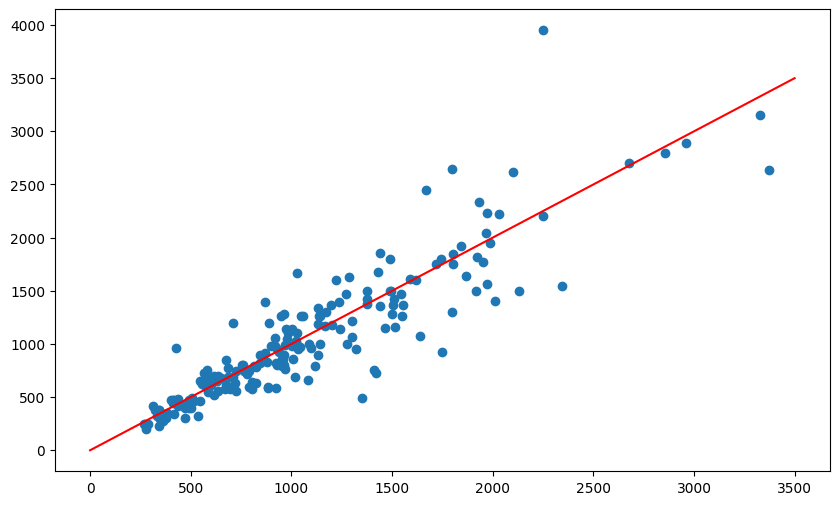

In [28]:
ypred = forest.predict(x_test_scaled)

plt.figure(figsize=(10,6))
plt.scatter(ypred, y_test)
plt.plot(range(0,3500), range(0,3500), c='red')